In [10]:
"short preprocessing"

# !pip install mne
# !pip install pyxdf
# !pip install PyWavelets
# !pip install pandas 
!pip install pyprep
!pip install numpy==1.21.6

from tqdm import tqdm
import pyxdf
import mne
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from copy import deepcopy
from matplotlib import pyplot
import matplotlib.pyplot as plt 
from mne.decoding import Scaler
import copy
import pathlib
from pathlib import Path
from typing import Dict, List, Optional, Union
from tqdm.auto import tqdm
# import plotly.graph_objects as go
# import plotly.subplots as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import argparse
from utils_clean import show_streams, find_stream, get_duration, get_time_series, set_channel_names, plot_channel_correlation,detect_bad_channels,plot_bads, ica_analysis,remove_breaks,build_class_epochs_mne,create_dataset,return_dataset,plot_topo,plot_eeg,plot_evoked,standartization

##ADDED:
import os
import mne
import numpy as np
import pickle
import pyprep
from pyprep.find_noisy_channels import NoisyChannels
from pyprep.prep_pipeline import PrepPipeline
import pandas as pd 
import argparse

import argparse


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement numpy==1.21.6 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 1.13.3, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 1.18.5, 1.19.0, 1.19.1, 1.19.2, 1.19.3, 1.19.4, 1.19.5,

In [8]:
# session_name = "S01"
# base_path = "/Users/arnavkapur/Desktop/EEG_Speech"
# data_path = os.path.join(base_path, "DATA","RAW")

# xdf_file_path = os.path.join(data_path, f"{session_name}.xdf")
xdf_file_path = "C:\\Users\\msi\\Desktop\\Constanze\\Docs\\DATA\\RAW\\S01.xdf"
# Load the .xdf file
data, header = pyxdf.load_xdf(xdf_file_path)
print(f"Successfully loaded data from {xdf_file_path}")

csv_file = "C:\\Users\\msi\\Desktop\\Constanze\\Docs\\DATA\\marker\\S01.csv"
df = pd.read_csv(csv_file, header=None)

2024-11-23 10:34:32,919 - pyxdf.pyxdf - INFO - Importing XDF file C:\Users\msi\Desktop\Constanze\Docs\DATA\RAW\S01.xdf...
2024-11-23 10:34:36,818 - pyxdf.pyxdf - INFO -   performing clock synchronization...
2024-11-23 10:34:36,903 - pyxdf.pyxdf - INFO -   performing jitter removal...


Successfully loaded data from C:\Users\msi\Desktop\Constanze\Docs\DATA\RAW\S01.xdf


In [9]:
print(np.__version__)

2.1.3


In [6]:
sample_rate = 500

show_streams(data)
eeg_stream = find_stream('eeg', data)
marker_stream = find_stream('marker', data)
df_marker = get_time_series(marker_stream)
sfreq = float(eeg_stream["info"]["nominal_srate"][0])

channels_info = eeg_stream['info']['desc'][0]['channels'][0]['channel']

# # Extract labels from each channel
ch_names = [channel['label'][0] for channel in channels_info]
ch_names = ['Fpz', 'Fp1', 'Fp2', 'AF3', 'AF4', 'AF7', 'AF8', 'Fz', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FCz', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'FT7', 'FT8', 'Cz', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'T7', 'T8', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'TP7', 'TP8', 'Pz', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'POz', 'PO3', 'PO4', 'PO5', 'PO6', 'PO7', 'PO8', 'Oz', 'O1', 'O2', 'ECG', 'HEOR', 'HEOL', 'VEOU', 'VEOL']



"""Create MNE file raw containing the EEG Stream"""

eeg_data = eeg_stream["time_series"].T
eeg_data = eeg_data[:64]
print(eeg_data.shape)
sfreq = float(eeg_stream["info"]["nominal_srate"][0])

eeg_info = mne.create_info(64, sfreq, ["eeg"]*64)
raw = mne.io.RawArray(eeg_data, eeg_info)

# review information
ssp_projectors = raw.info["projs"]
raw.del_proj()
# Calculate the duration in seconds and convert to minutes
duration_minutes = (raw.n_times / raw.info['sfreq']) / 60

# Print the duration in minutes
print(f"Duration of the recording: {duration_minutes:.2f} minutes")
useless_channels = ['ECG', 'HEOR', 'HEOL', 'VEOU', 'VEOL']

#ADDED:
raw.resample(sample_rate)
raw.set_montage('standard_1020', on_missing='warn')   
set_channel_names(raw,ch_names)
raw.drop_channels(useless_channels)  
ch_names_new = ['Fpz', 'Fp1', 'Fp2', 'AF3', 'AF4', 'AF7', 'AF8', 'Fz', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FCz', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'FT7', 'FT8', 'Cz', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'T7', 'T8', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'TP7', 'TP8', 'Pz', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'POz', 'PO3', 'PO4', 'PO5', 'PO6', 'PO7', 'PO8', 'Oz', 'O1', 'O2']




Channel 0:
Effective Rate: 0
Start TimeStamp: 
Channel Name: ['79522685']
Channel Type: ['Markers']
Time Series Length: 0
--------------------
Channel 1:
Effective Rate: 0
Start TimeStamp: 
Channel Name: ['LSLTrigger']
Channel Type: ['Markers']
Time Series Shape: (924, 1)
--------------------
Channel 2:
Effective Rate: 100.00000006066405
Start TimeStamp: 
Channel Name: ['E7240457_MEMsAll']
Channel Type: ['MEMsAll']
Time Series Shape: (332800, 9)
--------------------
Channel 3:
Effective Rate: 1000.000000052988
Start TimeStamp: 
Channel Name: ['E7240457_EEG']
Channel Type: ['EEG']
Time Series Shape: (3328000, 64)
--------------------
(64, 3328000)
Creating RawArray with float64 data, n_channels=64, n_times=3328000
    Range : 0 ... 3327999 =      0.000 ...  3327.999 secs
Ready.
Duration of the recording: 55.47 minutes
New channel names: ['Fpz', 'Fp1', 'Fp2', 'AF3', 'AF4', 'AF7', 'AF8', 'Fz', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FCz', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6',

C:\Users\msi\AppData\Local\Temp\ipykernel_15008\2869410118.py:39: RuntimeWarning: DigMontage is only a subset of info. There are 64 channel positions not present in the DigMontage. The channels missing from the montage are:

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage('standard_1020', on_missing='warn')


In [7]:
from pyprep.prep_pipeline import PrepPipeline

# Define preprocessing parameters
prep_params = {
    "ref_chs": "eeg",
    "reref_chs": "eeg",
    "line_freqs": np.arange(60, sample_rate / 2, 60),
}

# Assign a valid montage (standard 10-20 system)
montage = 'standard_1020'  # Use the name of the standard montage

RANSAC = False
print("Running pyprep")

prep = PrepPipeline(
    raw,
    prep_params,
    montage=montage,  # Pass the montage name
    ransac=RANSAC
)
prep.fit()
raw_new = prep.raw
print("Preprocessing completed.")
print("Still bad channels: ", raw_new.info['bads'])

# High-pass filter
raw_new.filter(l_freq=1, h_freq=None)


Running pyprep
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


KeyboardInterrupt: 

In [ ]:



eeg_start = eeg_stream['time_stamps'][0]  # EEG start time, 679.891
marker_start = marker_stream['time_stamps'][0]  # Marker start time, 2311465.920826529

time_offset = eeg_stream['clock_times'][0] - data[1]['clock_times'][0]
aligned_marker_relative = [(ts + time_offset - marker_start + eeg_start) for ts in data[1]['time_stamps']]

aligned_pairs = []
for marker_time in aligned_marker_relative:
    closest_idx = np.argmin(np.abs(np.array(eeg_stream['time_stamps']) - marker_time))
    aligned_pairs.append((marker_time, eeg_stream['time_stamps'][closest_idx]))
df_marker = pd.DataFrame(marker_stream['time_series'], aligned_marker_relative,columns=['marker'])


In [ ]:
# Extract the sentences column
sentences = df.iloc[2:, 0].values  # Ensure this is a numpy array or list for proper assignment
labels = df.iloc[2:, 1].values  # Ensure this is a numpy array or list for proper assignment

# Filter rows with marker == 1 and create a new column in df_marker
df_marker.loc[df_marker['marker'] == 1, 'sentences'] = sentences
df_marker.loc[df_marker['marker'] == 1, 'labels'] = labels
metadata = df_marker.loc[df_marker['marker'] == 1]
metadata = metadata.iloc[:-1]
metadata

,marker,sentences,labels
679.891112,1,"Do you want a cup of coffee, or would you pref...",4
689.691640,1,"Where did you put my keys, or did you see them...",2
696.343233,1,I need to go to the store to pick up some groc...,1
701.874266,1,"Can you help me with this project, or maybe sh...",0
708.573934,1,"I will be back in five minutes, so just wait h...",3
...,...,...,...
3893.043037,1,"Do you want a cup of coffee, or would you pref...",4
3898.277044,1,I need to go to the store to pick up some groc...,1
3936.526081,1,"I will be back in five minutes, so just wait h...",3
3964.427916,1,"Where did you put my keys, or did you see them...",2


In [ ]:
labels = df.iloc[2:-1, 1]
labels 

2      4
3      2
4      1
5      0
6      3
      ..
458    4
459    1
460    3
461    2
462    2
Name: 1, Length: 461, dtype: object

In [ ]:

sf = 500
eeg_time_series = raw_new.get_data()
eeg_time_series = eeg_time_series.T
eeg_timestamps = eeg_stream["time_stamps"]
event_time_series= marker_stream['time_series']
event_time_stamps= aligned_marker_relative

event_time_series_onset = df_marker[df_marker['marker'] == 1].reset_index()
event_time_series_offset = df_marker[df_marker['marker'] == 0].reset_index()
event_time_series_onset['numb'] = range(len(event_time_series_onset))
event_time_series_offset['numb'] = range(len(event_time_series_offset))
print("EVNETTIMESERIES", event_time_series_onset.shape)
print("EVENTTIMESERIESOFFSET", event_time_series_offset.shape)

eeg_closest_timestamps = []  

for event_time in event_time_stamps:
    closest_index = np.argmin(np.abs(eeg_timestamps - event_time))
    closest_timestamp = eeg_timestamps[closest_index]  
    eeg_closest_timestamps.append(closest_timestamp)


eeg_indeces = np.array(eeg_closest_timestamps)

labels = np.empty(eeg_timestamps.shape, dtype=int)
labels.fill(900) #Fill with 900 (break)
group_labels = np.copy(labels)
trials = np.copy(labels)

start = eeg_indeces[0]

eeg_data = eeg_time_series[:, :59]
out = pd.DataFrame(eeg_data, columns=ch_names_new)
print("OUT",out.shape)    


"Define the labels for the 5 sentences"

trial_label = df.iloc[2:-1, 1]
nan_count = trial_label.isna().sum()
trial_label = trial_label.dropna().astype(int)
print("Trial label shape", trial_label.shape)
print("Trial Labels:",trial_label)  

trial_label.index = range(len(trial_label))
event_time_series_offset['label'] = trial_label.astype(int)
event_time_series_offset = event_time_series_offset[:-1]
event_time_series_onset['label'] = trial_label.astype(int)  
event_time_series_onset = event_time_series_onset[:-1]


# Build the dataset
start_index = eeg_indeces[::2]
end_index = eeg_indeces[1::2]
start_index = start_index[:-1]
end_index = end_index[:-1]
print("START AND END", start_index.shape, end_index.shape, event_time_series_onset['label'].shape) #(461,) (461,) (461,)



durations = end_index - start_index
labels = np.full(len(eeg_timestamps), 900)

sf = sample_rate
for i in range(len(start_index)):
    start_idx = np.where(eeg_timestamps == start_index[i])[0]
    if len(start_idx) == 0:
        print(f"Start index {start_index[i]} not found in eeg_timestamps.")
        continue
    start_idx = start_idx[0]
        
    num_timestamps = int(durations[i] * sf)
    end_idx = min(start_idx + num_timestamps, len(eeg_timestamps))
    labels[start_idx:end_idx] = event_time_series_onset['label'][i]


# df = pd.DataFrame({'time': eeg_timestamps, 'label': labels})


dataset = []
df = pd.concat([pd.DataFrame({'time': eeg_timestamps, 'label': labels}), out], axis=1)
dataset.append(df)
dataset


def print_sample_distribution(labels):
    label_count = pd.Series(labels).value_counts().sort_index()

    print("Time sample distribution among different trials:")
    for label, count in label_count.items():
        print(f"Label {label}: {count} time samples")


label_count = df['label'].value_counts()
dataset[0]['label'].value_counts()

"Delete the breaks from the dataset"
#  using .query() to maintain the order of the columns removing th
dataset[0] = dataset[0].query("label != 900").reset_index(drop=True)

# using this to remove breaks without maining   the order of the columns
# dataset[0] = dataset[0].loc[dataset[0]['label'] != 900].reset_index(drop=True)
dataset[0]['label'].value_counts()

# Split the dataset based on the durations into trials
split_datasets = []
start_idx = 0
d =dataset[0]    

for duration in durations:
    end_idx = start_idx + int(duration * sf)
    split_df = d.iloc[start_idx:end_idx].copy()
    split_datasets.append(split_df)
    start_idx = end_idx

# # Verify the splits
# for i, split_df in enumerate(split_datasets):
#     print(f"Split {i}: {split_df.shape}")
# for dataset in split_datasets:
#     print(dataset['label'].value_counts())


d['time'].iloc[-1] - d['time'].iloc[0]

# Padding data to max timestamp
max_duration = 0
longest_array = None

for dataset in split_datasets:
    duration = d['time'].iloc[-1] - d['time'].iloc[0]
    if duration > max_duration:
        max_duration = duration
        longest_array = dataset

print("MAX Duration", max_duration)

max_length = max([dataset.shape[0] for dataset in split_datasets])

padded_dataset = []
for dataset in split_datasets:
    num_samples_to_pad = max_length - dataset.shape[0]
    
    if num_samples_to_pad > 0:
        label = d['label'].iloc[0]  
        padding_df = pd.DataFrame(0, index=range(num_samples_to_pad), columns=dataset.columns)
        padding_df['label'] = label 
        padded_dataset.append(pd.concat([dataset, padding_df], ignore_index=True))
    else:
        padded_dataset.append(dataset)

dataset_lengths = [dataset.shape[0] for dataset in padded_dataset]
print(f"Lengths after padding: {set(dataset_lengths)}")  
# for dataset in padded_dataset:
#     print(dataset['label'].value_counts())

dataset_lengths = [dataset.shape[0] for dataset in padded_dataset]

min_length = min(dataset_lengths)
max_length = max(dataset_lengths)

print(f"Minimum length: {min_length}")
print(f"Maximum length: {max_length}")

EVNETTIMESERIES (462, 5)
EVENTTIMESERIESOFFSET (462, 5)
OUT (1664000, 59)
Trial label shape (461,)
Trial Labels: 2      4
3      2
4      1
5      0
6      3
      ..
458    4
459    1
460    3
461    2
462    2
Name: 1, Length: 461, dtype: int64
START AND END (461,) (461,) (461,)
MAX Duration 3293.091999825506
Lengths after padding: {3598}
Minimum length: 3598
Maximum length: 3598


Created 923 events


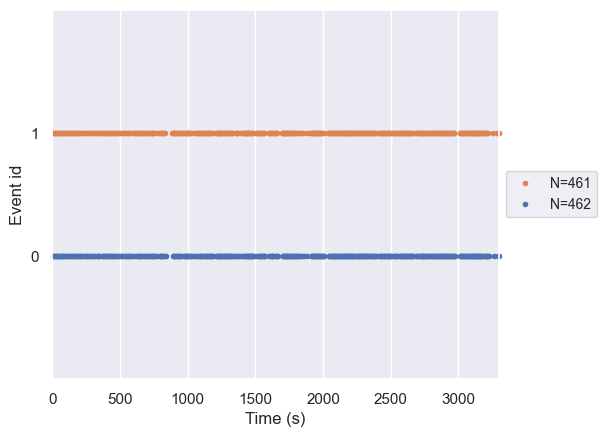

In [ ]:

sfreq = sf
# Convert aligned marker timestamps to sample indices relative to the EEG data
marker_sample_indices = [
    int((marker_time - eeg_stream['time_stamps'][0]) * sfreq) 
    for marker_time in aligned_marker_relative
]

# Create MNE-compatible events array
# Assuming `df_marker` contains a 'marker' column with the event codes
events = np.array([
    [sample_idx, 0, int(marker)] 
    for sample_idx, marker in zip(marker_sample_indices, df_marker['marker'])
])

# Filter out invalid events (e.g., negative sample indices)
events = events[events[:, 0] > 0]

# Add the events to the Raw object
print(f"Created {len(events)} events")
mne.viz.plot_events(events, sfreq=sfreq)

events = events[events[:, 2] == 1]


In [ ]:
metadata

,marker,sentences,labels
679.891112,1,"Do you want a cup of coffee, or would you pref...",4
689.691640,1,"Where did you put my keys, or did you see them...",2
696.343233,1,I need to go to the store to pick up some groc...,1
701.874266,1,"Can you help me with this project, or maybe sh...",0
708.573934,1,"I will be back in five minutes, so just wait h...",3
...,...,...,...
3893.043037,1,"Do you want a cup of coffee, or would you pref...",4
3898.277044,1,I need to go to the store to pick up some groc...,1
3936.526081,1,"I will be back in five minutes, so just wait h...",3
3964.427916,1,"Where did you put my keys, or did you see them...",2


In [ ]:
tmax = max_duration/sample_rate +0.1
epochs = mne.Epochs(
    raw, 
    events, 
    event_id=None, 
    tmin=0, 
    tmax= tmax, 
    metadata=metadata, 
    baseline=None,  # No baseline correction
    preload=True, 
    reject= None, 
    reject_by_annotation = False, 
    on_missing='ignore'  # Allow shorter epochs
)

print(f"Metadata shape: {epochs.metadata.shape}")


Adding metadata with 3 columns
461 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 461 events and 3344 original time points ...
0 bad epochs dropped
Metadata shape: (461, 3)


In [ ]:
# !pip install autoreject
# from autoreject import AutoReject
# ar = AutoReject()
# epochs_clean_r, reject_log_r = ar.fit_transform(epochs, return_log=True)
# # epochs_clean_i, reject_log_i = ar.fit_transform(epochs_i, return_log=True)
# # else:
# #     print("Not running autoreject")
# #     epochs_clean_r = epochs
# #     epochs_clean_i = epochs

In [ ]:
# !pip install mne_icalabel
# from mne_icalabel import label_components
# epochs_clean_r = epochs

# ica_r = mne.preprocessing.ICA(n_components=30, random_state=97, max_iter="auto",method='infomax', fit_params=dict(extended=True)) # 使用extended-infomax算法
# ica_r.fit(epochs_clean_r)
# ic_labels_r = label_components(epochs_clean_r, ica_r, method="iclabel")
# labels_r = ic_labels_r["labels"]
# exclude_idx_r = [
#     idx for idx, label in enumerate(labels_r) if label not in ["brain", "other"]
# ]
# print(f"Reading Epochs Excluding these ICA components: {exclude_idx_r}")
# epochs_clean_r_reconstructed = epochs_clean_r.copy()
# ica_r.apply(epochs_clean_r_reconstructed, exclude=exclude_idx_r)

# # ica_i = mne.preprocessing.ICA(n_components=30, random_state=97, max_iter="auto",method='infomax', fit_params=dict(extended=True))
# # ica_i.fit(epochs_clean_i)
# # ic_labels_i = label_components(epochs_clean_i, ica_i, method="iclabel")
# # labels_i = ic_labels_i["labels"]
# # exclude_idx_i = [
# #     idx for idx, label in enumerate(labels_i) if label not in ["brain", "other"]
# # # ]
# # # print(f"Imagine Epochs Excluding these ICA components: {exclude_idx_i}")
# # epochs_clean_i_reconstructed = epochs_clean_i.copy()
# # ica_i.apply(epochs_clean_i_reconstructed, exclude=exclude_idx_i)


In [ ]:
epochs

<Epochs | 461 events (all good), 0 – 1 s (baseline off), ~104.0 MB, data loaded, with metadata,
 '1': 461>

In [ ]:
import os
import pickle

# File path to save the pickle file
file_path = "C:\\Users\\msi\\Desktop\\Constanze\\Docs\\DATA\\PREPROCESSED\\PREP_CH\\data.pkl"

# # Drop bad epochs if they haven't been dropped yet
# if not epochs._bad_dropped:
#     epochs.drop_bad()

# Prepare the list to save data
data_to_save = []
for epoch_idx in range(len(epochs)):
    # Extract sentence (or None if metadata is unavailable)
    sentence = (
        epochs.metadata.iloc[epoch_idx]['sentences'] 
        if epochs.metadata is not None else None
    )

    # Extract epoch data without copying
    data = epochs[epoch_idx].get_data(copy=True)
    print(f"Epoch {epoch_idx} data shape: {data.shape}")

    # Append data and metadata to the list
    data_to_save.append({"text": sentence, "input_features": data})

# Open the file in binary write mode and save the data
with open(file_path, 'wb') as file:
    pickle.dump(data_to_save, file)

print(f"Data successfully saved to {file_path}")


Epoch 0 data shape: (1, 59, 3344)
Epoch 1 data shape: (1, 59, 3344)
Epoch 2 data shape: (1, 59, 3344)
Epoch 3 data shape: (1, 59, 3344)
Epoch 4 data shape: (1, 59, 3344)
Epoch 5 data shape: (1, 59, 3344)
Epoch 6 data shape: (1, 59, 3344)
Epoch 7 data shape: (1, 59, 3344)
Epoch 8 data shape: (1, 59, 3344)
Epoch 9 data shape: (1, 59, 3344)
Epoch 10 data shape: (1, 59, 3344)
Epoch 11 data shape: (1, 59, 3344)
Epoch 12 data shape: (1, 59, 3344)
Epoch 13 data shape: (1, 59, 3344)
Epoch 14 data shape: (1, 59, 3344)
Epoch 15 data shape: (1, 59, 3344)
Epoch 16 data shape: (1, 59, 3344)
Epoch 17 data shape: (1, 59, 3344)
Epoch 18 data shape: (1, 59, 3344)
Epoch 19 data shape: (1, 59, 3344)
Epoch 20 data shape: (1, 59, 3344)
Epoch 21 data shape: (1, 59, 3344)
Epoch 22 data shape: (1, 59, 3344)
Epoch 23 data shape: (1, 59, 3344)
Epoch 24 data shape: (1, 59, 3344)
Epoch 25 data shape: (1, 59, 3344)
Epoch 26 data shape: (1, 59, 3344)
Epoch 27 data shape: (1, 59, 3344)
Epoch 28 data shape: (1, 59, 3

In [ ]:
# import pickle
# # import torch
# import numpy 

# def load_preprocessed_data(file_path: str):
#     """
#     Loads preprocessed data from the given pickle file.
#     Adjusts shapes and data types as needed for downstream processing.
#     """
#     if not os.path.exists(file_path):
#         raise FileNotFoundError(f"File not found at {file_path}")
    
#     # Load the preprocessed data
#     with open(file_path, "rb") as file:
#         data = pickle.load(file)
#         print( len(data))



#     dsplit = {"input_features": [], "labels": []}
#     for idx, trial in enumerate(data):
#         # Extract `text` and `input_features`
#         text = trial["text"]
#         # input_features = trial["input_features"]
#         input_features = trial['input_features'][0, :59, :]*1000000
#         mean = numpy.absolute(numpy.mean(input_features, axis=1))
#         stds = numpy.std(input_features, axis=1)
#         # Ensure `input_features` is a numpy array and has the correct shape
#         if not isinstance(input_features, np.ndarray):
#             input_features = np.array(input_features)

#         # Check the expected shape of input_features (adjust based on your saving format)
#         # Your shape: (1, 59, 501) -> Remove the first dimension
#         assert input_features.shape[0] == 1, f"Unexpected shape: {input_features.shape}"
#         input_features = input_features[0]

#         # Convert to float32 for compatibility
#         input_features = np.float32(input_features)
#         # input_features = torch.tensor(input_features)

#         # Add to the dataset
#         dsplit["input_features"].append(input_features)
#         dsplit["labels"].append(text)

#     print(f"Loaded {len(dsplit['input_features'])} trials from {file_path}")
#     return dsplit

# def get_dataset_from_path(file_path: str):
#     """
#     Wrapper for loading dataset.
#     """
#     return load_preprocessed_data(file_path)

# # Example Usage
# file_path = "C:\\Users\\msi\\Desktop\\Constanze\\Docs\\DATA\\PREPROCESSED\\PREP_CH\\data.pkl"
# dataset = get_dataset_from_path(file_path)

# # Check dataset structure
# print(f"Number of trials: {len(dataset['input_features'])}")
# print(f"Shape of first trial: {dataset['input_features'][0].shape}")
# print(f"First label: {dataset['labels'][0]}")


461


AssertionError: Unexpected shape: (59, 3344)

In [ ]:
# import torch
# Load the preprocessed data

paths = "C:\\Users\\msi\\Desktop\\Constanze\\Docs\\DATA\\PREPROCESSED\\PREP_CH\\data.pkl"

def get(file_path: str):

    with open(paths, "rb") as file:
            data = pickle.load(file)
            print( len(data))
    
    pickles = data
    for idx, trial in enumerate(pickles):
        assert isinstance(trial['input_features'], numpy.ndarray)
        assert trial['input_features'].dtype == numpy.float64
        assert trial['input_features'].shape == (1, 125, 1651)
        input_features = trial['input_features'][0, :59, :]*1000000
        mean = np.absolute(np.mean(input_features, axis=1))
        stds = np.std(input_features, axis=1)
        assert isinstance(input_features, numpy.ndarray)
        assert input_features.dtype == numpy.float64
        assert input_features.shape == (59, 1651)
        assert (mean > 0).all() and (mean < 10000).all()
        assert (stds > 0).all() and (stds < 10000).all()
    return pickles

def get_dataset(pickles):
    dsplit = {"input_features": [], "labels": []}
    for epoch in range(1, 46): ## CHECK WHY 46
        
        for trial in pickles:
            input_features = trial['input_features'][0, :59, :]*1000000
            input_ids = trial['text'].strip()

            input_features = np.float32(input_features)
            input_features = torch.tensor(input_features)
            dsplit["input_features"].append(input_features)
            dsplit["labels"].append(input_ids)
    return dsplit


